# Systemy Wbudowane i Przetwarzanie Brzegowe

### Politechnika Poznańska, Instytut Robotyki i Inteligencji Maszynowej

<p align="center">
    <img width="180" height="180" src="https://drive.google.com/uc?id=1ZlNtXslyrqbmiR5B_PqXHIS07UYrd-H5" />
</p>

### **Ćwiczenie laboratoryjne 6: Metody optymalizacji sieci neuronowych**

## Wstęp

Jako najbardziej powszchne metody akceleracji obliczeń, ale także optymalizacji parametrów sieci neuronowych (np. rozmiar modelu) możemy wymienić:
- kwantyzacja wag (ang. quantization)
- łączenie warstw (ang. layer fusion)
- uczenie z uwzględnieniem kwantyzacji (ang. quantization aware training)
- usuwaniu parametrów (ang. pruning)
- klasteryzacja wag (ang. weight clustering)
- destylacja wiedzy (ang. knowledge distillation)
- faktoryzacja niskiego poziomowa (ang. low-rank factorization)
- optymalizacja zbiorowa (ang. collaborative optimization)
- przetwarzanie partiami (ang. batch processing)
- przetwarzanie równoległe i asynchroniczne (ang. parallel processing and asynchronous processing)

## Zadania do samodzielnej realizacji

1. Postępuj zgodnie z komórkami notatnika, stosując się do zamieszczonych zadań, instrukcji oraz wskazówek.  

### Zbiór danych

[Human Segmentation Dataset](https://github.com/VikramShenoy97/Human-Segmentation-Dataset/tree/master)


<img src="https://github.com/VikramShenoy97/Human-Segmentation-Dataset/blob/master/Training_Images/87.jpg?raw=true" width=500>
<img src="https://github.com/VikramShenoy97/Human-Segmentation-Dataset/blob/master/Ground_Truth/87.png?raw=true" width=500>

In [ ]:
!git clone https://github.com/VikramShenoy97/Human-Segmentation-Dataset.git

Cloning into 'Human-Segmentation-Dataset'...
remote: Enumerating objects: 596, done.
remote: Total 596 (delta 0), reused 0 (delta 0), pack-reused 596 (from 1)
Receiving objects: 100% (596/596), 13.60 MiB | 35.08 MiB/s, done.
Resolving deltas: 100% (7/7), done.


### Moduły pomocnicze

Poniższe pliki należy pobrać i dodać do notatnika Colab.

- [dataset.py](https://drive.google.com/file/d/15cKwDoW8B7whEcMTdhhPvhK0Dh4zu_JU/view?usp=sharing)
- [model.py](https://drive.google.com/file/d/1ikZe4EtyAudhUhjNgKVSRDX-ywIS5kkQ/view?usp=sharing)
- [utils.py](https://drive.google.com/file/d/19Y9HBC7Y7RjJJ0LHc6VfdwbaSJHVpgKg/view?usp=sharing)

### Instalacja bibliotek

In [ ]:
!pip install --quiet albumentations lightning monai segmentation-models-pytorch onnx onnxruntime onnxconverter_common torch-pruning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.

### Import bibliotek

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

### Wizualizacja danych

In [ ]:
dataset_path = Path('./Human-Segmentation-Dataset')
images_path = dataset_path / 'Training_Images'
masks_path = dataset_path / 'Ground_Truth'

images = list(images_path.glob('*.jpg'))
images_num = len(images)
masks_num = len(list(masks_path.glob('*.png')))

print('-'*25)
print(f'Images: {images_num}')
print(f'Masks: {masks_num}')
print('-'*25)

train_images, valtest_images = train_test_split(images, train_size=0.6)
val_images, test_images = train_test_split(valtest_images, train_size=0.5)

print(f'Train set: {len(train_images)}')
print(f'Val set: {len(val_images)}')
print(f'Test set: {len(test_images)}')
print('-'*25)

-------------------------
Images: 290
Masks: 290
-------------------------
Train set: 174
Val set: 58
Test set: 58
-------------------------


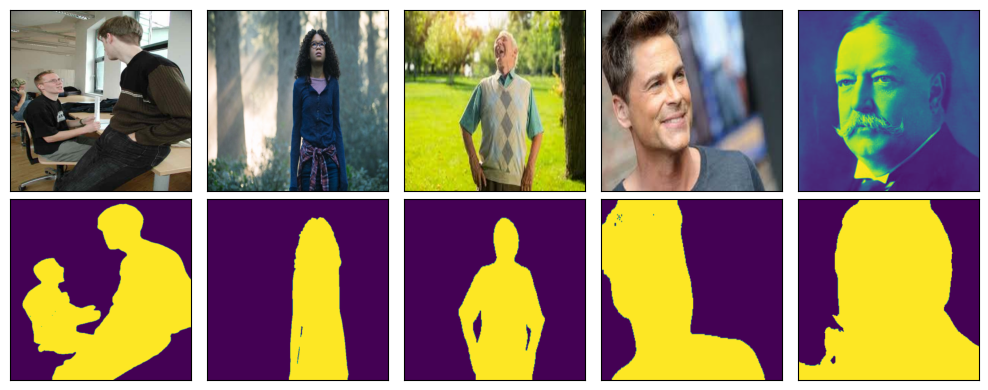

In [ ]:
def load_image(file_path: Path, shape: tuple[int]) -> np.ndarray:
  return np.asarray(Image.open(file_path).resize(shape))


shape = (320, 320)
indexes = np.random.randint(1, images_num, 5)

fig, ax = plt.subplots(2, len(indexes), figsize=(2*len(indexes), 4))

for idx, file_idx in enumerate(indexes):
  img = load_image(images_path / f'{file_idx}.jpg', shape)
  mask = load_image(masks_path / f'{file_idx}.png', shape)
  ax[0][idx].imshow(img)
  ax[1][idx].imshow(mask)
  ax[0][idx].set_xticks([])
  ax[0][idx].set_yticks([])
  ax[1][idx].set_xticks([])
  ax[1][idx].set_yticks([])

plt.tight_layout()
plt.show()

### ML model

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


augmentations = A.Compose(
  [
    A.ToFloat(),
    A.HorizontalFlip(),
    A.OneOf([A.GaussNoise(), A.GaussianBlur()]),
    A.Affine(rotate=5, shear=5),
    A.ElasticTransform(),
    A.RandomGridShuffle(grid=(8, 8), p=0.25),
    ToTensorV2(),
  ]
)

transforms = A.Compose([
  ToTensorV2(),
])

In [ ]:
from dataset import SegmentationDataset


train_dataset = SegmentationDataset(dataset_path, train_images, shape=(320, 320), transforms=augmentations)
val_dataset = SegmentationDataset(dataset_path, val_images, shape=(320, 320), transforms=transforms)
test_dataset = SegmentationDataset(dataset_path, test_images, shape=(320, 320), transforms=transforms)

In [ ]:
from torch.utils.data import DataLoader


batch_size = 8
number_of_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, drop_last=True, num_workers=number_of_workers,)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=number_of_workers,)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, num_workers=number_of_workers,)

In [ ]:
from model import Segmenter


model = Segmenter(
  encoder_name='resnet18',
  encoder_weights='imagenet',
  in_channels=3,
  out_channels=1,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


In [ ]:
import lightning.pytorch as pl


epochs = 15
precision = '32'
accelerator = 'gpu'

trainer = pl.Trainer(
  callbacks=[
      pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, save_last=False, verbose=True, dirpath='./checkpoints', filename='epoch_{epoch}-{val_loss:.5f}',  auto_insert_metric_name=False),
      pl.callbacks.EarlyStopping(monitor='val_loss', patience=10),
      pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
  ],
  accelerator=accelerator,
  devices=1,
  precision=precision,
  max_epochs=epochs,
  benchmark=True,
  sync_batchnorm=False,
  strategy='auto',
  check_val_every_n_epoch=1,
  log_every_n_steps=10,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | activation    | Sigmoid          | 0      | train
1 | network       | Unet             | 14.3 M | train
2 | loss          | DiceLoss         | 0      | train
3 | train_metrics | MetricCollection | 0      | train
4 | val_metrics   | MetricCollection | 0      | train
5 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | activ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 21: 'val_loss' reached 0.41249 (best 0.41249), saving model to '/content/checkpoints/epoch_0-0.41249.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 21: 'val_loss' reached 0.41249 (best 0.41249), saving model to '/content/checkpoints/epoch_0-0.41249.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 42: 'val_loss' reached 0.36254 (best 0.36254), saving model to '/content/checkpoints/epoch_1-0.36254.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 42: 'val_loss' reached 0.36254 (best 0.36254), saving model to '/content/checkpoints/epoch_1-0.36254.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 63: 'val_loss' reached 0.34018 (best 0.34018), saving model to '/content/checkpoints/epoch_2-0.34018.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 63: 'val_loss' reached 0.34018 (best 0.34018), saving model to '/content/checkpoints/epoch_2-0.34018.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 84: 'val_loss' reached 0.33955 (best 0.33955), saving model to '/content/checkpoints/epoch_3-0.33955.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 84: 'val_loss' reached 0.33955 (best 0.33955), saving model to '/content/checkpoints/epoch_3-0.33955.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 105: 'val_loss' reached 0.33902 (best 0.33902), saving model to '/content/checkpoints/epoch_4-0.33902.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 105: 'val_loss' reached 0.33902 (best 0.33902), saving model to '/content/checkpoints/epoch_4-0.33902.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 126: 'val_loss' reached 0.33851 (best 0.33851), saving model to '/content/checkpoints/epoch_5-0.33851.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 126: 'val_loss' reached 0.33851 (best 0.33851), saving model to '/content/checkpoints/epoch_5-0.33851.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 147: 'val_loss' reached 0.33800 (best 0.33800), saving model to '/content/checkpoints/epoch_6-0.33800.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 147: 'val_loss' reached 0.33800 (best 0.33800), saving model to '/content/checkpoints/epoch_6-0.33800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 168: 'val_loss' reached 0.33749 (best 0.33749), saving model to '/content/checkpoints/epoch_7-0.33749.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 168: 'val_loss' reached 0.33749 (best 0.33749), saving model to '/content/checkpoints/epoch_7-0.33749.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 189: 'val_loss' reached 0.33697 (best 0.33697), saving model to '/content/checkpoints/epoch_8-0.33697.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 189: 'val_loss' reached 0.33697 (best 0.33697), saving model to '/content/checkpoints/epoch_8-0.33697.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 210: 'val_loss' reached 0.33644 (best 0.33644), saving model to '/content/checkpoints/epoch_9-0.33644.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 210: 'val_loss' reached 0.33644 (best 0.33644), saving model to '/content/checkpoints/epoch_9-0.33644.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 231: 'val_loss' reached 0.33593 (best 0.33593), saving model to '/content/checkpoints/epoch_10-0.33593.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 231: 'val_loss' reached 0.33593 (best 0.33593), saving model to '/content/checkpoints/epoch_10-0.33593.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 252: 'val_loss' reached 0.33541 (best 0.33541), saving model to '/content/checkpoints/epoch_11-0.33541.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 252: 'val_loss' reached 0.33541 (best 0.33541), saving model to '/content/checkpoints/epoch_11-0.33541.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 273: 'val_loss' reached 0.33491 (best 0.33491), saving model to '/content/checkpoints/epoch_12-0.33491.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 273: 'val_loss' reached 0.33491 (best 0.33491), saving model to '/content/checkpoints/epoch_12-0.33491.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 294: 'val_loss' reached 0.33440 (best 0.33440), saving model to '/content/checkpoints/epoch_13-0.33440.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 294: 'val_loss' reached 0.33440 (best 0.33440), saving model to '/content/checkpoints/epoch_13-0.33440.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 315: 'val_loss' reached 0.33391 (best 0.33391), saving model to '/content/checkpoints/epoch_14-0.33391.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 315: 'val_loss' reached 0.33391 (best 0.33391), saving model to '/content/checkpoints/epoch_14-0.33391.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


### Ewaluacja modelu

In [ ]:
model.eval()
trainer.test(model, test_dataloader, ckpt_path=None)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_BinaryF1Score     │    0.8729289174079895     │
│   test_BinaryPrecision    │    0.8042075634002686     │
│     test_BinaryRecall     │     0.954492449760437     │
│      test_DiceScore       │    0.6864009499549866     │
│         test_loss         │    0.31359899044036865    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.31359899044036865,
  'test_BinaryF1Score': 0.8729289174079895,
  'test_BinaryPrecision': 0.8042075634002686,
  'test_BinaryRecall': 0.954492449760437,
  'test_DiceScore': 0.6864009499549866}]

In [ ]:
def predict_sample(model, dataset, conf_thresh: float = 0.5):
  idx = np.random.randint(0, dataset.__len__())
  image, mask = dataset.__getitem__(idx)

  predicted_mask = model(image[np.newaxis, ...])
  predicted_mask = predicted_mask.detach().numpy()[0][0]
  predicted_mask = np.where(predicted_mask < conf_thresh, 0, 255).astype(np.uint8)

  fig, ax = plt.subplots(1, 3, figsize=(12, 4))
  ax[0].imshow(image.numpy().transpose((1, 2, 0)))
  ax[1].imshow(mask.numpy()[0])
  ax[2].imshow(predicted_mask)

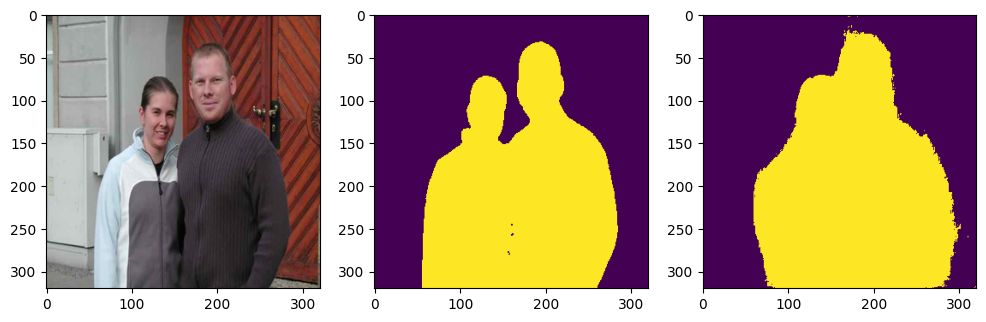

In [ ]:
predict_sample(model, test_dataset)

---
## Przetwarzanie partiami
---
Grupowanie i przetwarzanie partiami (ang. batch processing) pozwala znacznie przyspieszyć wnioskowanie modelu, jednak nie zawsze istnieje możliwość zrównoleglenia tego procesu np. w przypadku bezpośredniego przetwarzania sygnałów w czasie rzeczywistym. Z drugiej strony, w takim przypadku można skorzystać z metody dzielenie sygnału wejściowego na tak zwane "okna" lub fragmenty pozwalające na osiągnięcie lepszych wyników metrycznych bez np. skalowania / zmiany rozmiaru danych wejściowych.

In [ ]:
from time import perf_counter


def calc_avg_model_infer_time(model, batch_size: int) -> tuple[float, float]:
  size = 64
  input_data = torch.randn(size, 3, 320, 320, dtype=torch.float32, device=model.device)

  infer_times = []

  for _ in range(5):
    for idx in range(0, size, batch_size):
      inference_start = perf_counter()
      __ = model(input_data[idx : idx + batch_size])
      inference_time = perf_counter() - inference_start
      infer_times.append(inference_time / batch_size)

  return np.mean(infer_times), np.std(infer_times)

**Zadanie 1.**</br>
Korzystając z funkcji `calc_avg_model_infer_time` zbadaj czas inferencji modelu UNet z enkoderem ResNet18 w zależności od rozmiaru wejściowego. Testy przeprowadź dla `batch_size` równego 1, 2, 4, 8, 16, 32. Wartości zwracane przez powyższą funkcję dodaj do list `avg_infer_times` i `std_infer_times`. W miarę możliwości wykonaj zadanie zarówno na CPU jak i na GPU.


In [ ]:
avg_infer_times = []
std_infer_times = []

##### Student code #####

batch_sizes = [1, 2, 4, 8, 16, 32]

# Collect inference time stats
with torch.no_grad():
    for bs in batch_sizes:
        avg, std = calc_avg_model_infer_time(model, bs)
        avg_infer_times.append(avg)
        std_infer_times.append(std)

########################


# Przedstaw powyższe wyniki w formie wykresu
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(len(avg_infer_times)), avg_infer_times, yerr=std_infer_times, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Inference time [s]', fontsize=16)
ax.set_xlabel('Batch size', fontsize=16)
ax.set_xticks(np.arange(len(avg_infer_times)), labels=batch_sizes, fontsize=14)
ax.set_title('Inference time on GPU for 32 random\nsamples depending on batch size', fontsize=18)
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

---

# Optymalizacja modelu

Obszary optymalizacji modeli neuronowych:
- czas wnioskowania
- rozmiar
- liczba wykonywanych operacji

---

In [ ]:
##### Student code #####

ckpt_path = "/content/checkpoints/epoch_14-0.33391.ckpt"

########################

In [ ]:
from utils import get_size, count_parameters, sparsity, measure_latency, export_onnx

In [ ]:
model = Segmenter.load_from_checkpoint(ckpt_path)

# parametry modelu
torch_model_name = 'model_fp32.pth'
torch.save(model, torch_model_name)
model_size = get_size(torch_model_name)
print(f'PyTorch baseline model size: {model_size}')
parameters = count_parameters(model)
print(f'Baseline model parameters: {parameters}')
print(f'Baseline model sparisty: {sparsity(model)}')

# eksport PyTorch -> ONNX
onnx_model_name = 'model_fp32.onnx'
export_onnx(model, onnx_model_name=onnx_model_name)
model_size = get_size(onnx_model_name)
print(f'ONNX baseline model size: {model_size}')

# pomiar czasu wnioskowania
model_latency = measure_latency(model)
print(f'Average baseline model inference time: {model_latency * 1000} ms')

PyTorch baseline model size: 54.8 MB
Baseline model parameters: 14328209
Baseline model sparisty: 0.0
ONNX baseline model size: 54.7 MB
Average baseline model inference time: 9.311103999834813 ms


---

# Pruning

---



In [ ]:
from copy import deepcopy

import torch
import torch.nn.utils.prune as prune


def prune_model(model, method, sparsity_amount=0.5):
  for name, m in model.named_modules():
    if isinstance(m, torch.nn.Conv2d):
      if method == 'l1_unstructured':
        prune.l1_unstructured(m, name='weight', amount=sparsity_amount)
      elif method == 'ln_structured':
        prune.ln_structured(m, name='weight', amount=sparsity_amount, n=float('-inf'), dim=2)
      elif method == 'random_unstructured':
        prune.random_unstructured(m, name='weight', amount=sparsity_amount)
      elif method == 'random_structured':
        prune.random_structured(m, name='weight', amount=sparsity_amount, dim=1)
      else:
        raise NameError(f'Unsupported method: {method}')
      prune.remove(m, 'weight')  # make permanent

  # print(f'Model pruned with {method} to {sparsity(model):.3g} global sparsity')
  return model


model = Segmenter.load_from_checkpoint(ckpt_path)
print(f'Baseline model sparisty: {sparsity(model)}')

In [ ]:
##### Student code #####

sparsity_amount = 0.2

########################

trainer = pl.Trainer(precision='32', accelerator=accelerator, devices=1)

for pruning_method in ['l1_unstructured', 'ln_structured', 'random_unstructured', 'random_structured']:
  print(f'Pruned model with {pruning_method} method')
  model_pruned = prune_model(deepcopy(model), method=pruning_method, sparsity_amount=sparsity_amount)

  metrics = trainer.test(model_pruned, test_dataloader, ckpt_path=None, verbose=False)

  print(f'\tSparisty: {sparsity(model_pruned)}')
  print(f'\tDice score: {metrics[0]["test_DiceScore"]}')

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Pruned model with l1_unstructured method


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


	Sparisty: 0.19983837008476257
	Dice score: 0.6692168116569519
Pruned model with ln_structured method


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


	Sparisty: 0.3289365768432617
	Dice score: 0.3228680193424225
Pruned model with random_unstructured method


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


	Sparisty: 0.19983837008476257
	Dice score: 0.32121434807777405
Pruned model with random_structured method


Testing: |          | 0/? [00:00<?, ?it/s]

	Sparisty: 0.199656143784523
	Dice score: 0.36370980739593506


**Zadanie 2.**</br>
Korzystając z funkcji `prune_model` zbadaj wpływ współczynnika `sparsity_amount` na metrykę dice score zbioru testowego dla wybranej metody (`l1_unstructured`, `ln_structured`, `random_unstructured`, `random_structured`). Testy przeprowadź dla współczynnika równego 0.0, 0.1, 0.15, 0.25, 0.5, 0.75. Wyniki dodaj do listy `pruned_model_dice_score`

Do wyliczenia metryk skorzystaj z polecenia:
```
trainer.test(model_pruned, test_dataloader, ckpt_path=None, verbose=False)
```


INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

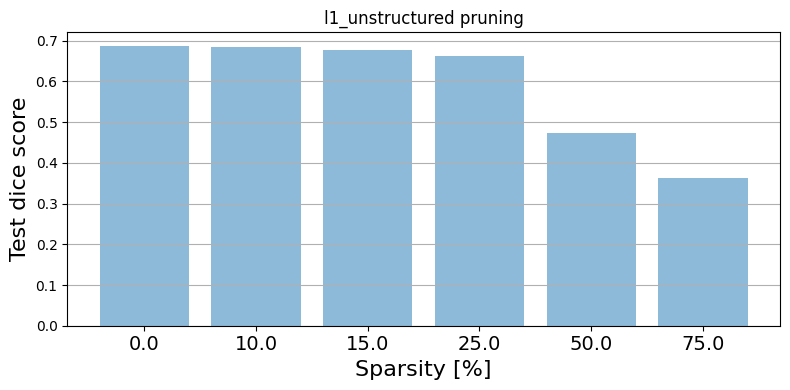

In [ ]:
pruned_model_dice_score = []

trainer = pl.Trainer(precision='32', accelerator=accelerator, devices=1)


##### Student code #####

pruning_method = 'l1_unstructured'
sparsities = [0.0, 0.1, 0.15, 0.25, 0.5, 0.75]

base_model = Segmenter.load_from_checkpoint(ckpt_path)

for ss in sparsities:
    model_copy = deepcopy(base_model)
    model_copy = prune_model(model_copy, method=pruning_method, sparsity_amount=ss)

    # Evaluate
    test_result = trainer.test(model_copy, test_dataloader, ckpt_path=None, verbose=False)
    dice_score = test_result[0]['test_DiceScore']  # Assumes this metric key

    pruned_model_dice_score.append(dice_score)

########################


fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(len(pruned_model_dice_score)), pruned_model_dice_score, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Test dice score', fontsize=16)
ax.set_xlabel('Sparsity [%]', fontsize=16)
ax.set_xticks(np.arange(len(sparsities)), labels=np.array(sparsities)*100, fontsize=14)
ax.yaxis.grid(True)
ax.set_title(f'{pruning_method} pruning')

plt.tight_layout()
plt.show()

---

## Kwantyzacja

---

### FLOAT 32

---

In [ ]:
model = Segmenter.load_from_checkpoint(ckpt_path)
model_copy = deepcopy(model)
model_copy = prune_model(model_copy, method='l1_unstructured', sparsity_amount=0.1)
trainer = pl.Trainer(precision='32', accelerator=accelerator, devices=1)
metrics = trainer.test(model_copy.float(), test_dataloader, ckpt_path=None)
print(f'Model data type: {model_copy.float().dtype}')
print(metrics)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilitie

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_BinaryF1Score     │    0.8736086487770081     │
│   test_BinaryPrecision    │    0.8059972524642944     │
│     test_BinaryRecall     │    0.9536018371582031     │
│      test_DiceScore       │    0.6836363077163696     │
│         test_loss         │     0.316363662481308     │
└───────────────────────────┴───────────────────────────┘

Model data type: torch.float32
[{'test_loss': 0.316363662481308, 'test_BinaryF1Score': 0.8736086487770081, 'test_BinaryPrecision': 0.8059972524642944, 'test_BinaryRecall': 0.9536018371582031, 'test_DiceScore': 0.6836363077163696}]


In [ ]:
torch.save(model_copy.float(), 'model_fp32.pth')
model_size = get_size('model_fp32.pth')
print(f'Model file size: {model_size}')

Model file size: 54.8 MB


### FLOAT 16

---


In [ ]:
model = Segmenter.load_from_checkpoint(ckpt_path)
model_copy = deepcopy(model)
model_copy = prune_model(model_copy, method='l1_unstructured', sparsity_amount=0.1)
trainer = pl.Trainer(precision='16', accelerator=accelerator, devices=1)
metrics = trainer.test(model_copy.half(), test_dataloader, ckpt_path=None)
print(f'Model data type: {model.half().dtype}')
print(metrics)

/usr/local/lib/python3.11/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_BinaryF1Score     │    0.8736686706542969     │
│   test_BinaryPrecision    │    0.8061099648475647     │
│     test_BinaryRecall     │    0.9535872340202332     │
│      test_DiceScore       │    0.6835970282554626     │
│         test_loss         │    0.31640294194221497    │
└───────────────────────────┴───────────────────────────┘

Model data type: torch.float16
[{'test_loss': 0.31640294194221497, 'test_BinaryF1Score': 0.8736686706542969, 'test_BinaryPrecision': 0.8061099648475647, 'test_BinaryRecall': 0.9535872340202332, 'test_DiceScore': 0.6835970282554626}]


In [ ]:
torch.save(model_copy.half(), 'model_fp16.pth')
model_size = get_size('model_fp16.pth')
print(f'Model file size: {model_size}')

Model file size: 27.5 MB


---

# ONNX

---

In [ ]:
import onnx
import onnxruntime as ort
from onnxconverter_common import float16
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime.quantization.shape_inference import quant_pre_process

In [ ]:
##### Student code #####

onnx_model_fp32_path = '/content/model_fp32.onnx'

########################

print(f'ONNX baseline model size: {get_size(onnx_model_fp32_path)}')

ONNX baseline model size: 54.7 MB


### FLOAT16

In [ ]:
onnx_model_fp32 = onnx.load(onnx_model_fp32_path)
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model_fp32)
onnx.save(onnx_model_fp16, 'model_fp16.onnx')

model_size = get_size('model_fp16.onnx')
print(f'ONNX baseline model size: {model_size}')

/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 2.883414514098792e-11 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -2.2250328315931434e-11 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 3.4401683723928045e-09 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -5.10925310948096e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".forma

ONNX baseline model size: 27.4 MB


### UINT8

In [ ]:
onnx_model_uint8_path = 'model_uint8.onnx'
quant_pre_process(onnx_model_fp32_path, 'preprocessed_model_fp32.onnx')
quantize_dynamic('preprocessed_model_fp32.onnx', onnx_model_uint8_path, weight_type=QuantType.QUInt8)

model_size = get_size(onnx_model_uint8_path)
print(f'ONNX baseline model size: {model_size}')

ONNX baseline model size: 13.8 MB


## Ewaluacja modeli ONNX

In [ ]:
def preprocess(image, dtype=np.float32):
  image = (image / 255).astype(dtype)
  image = np.transpose(image, (2, 0, 1))

  return image[np.newaxis, ...]


def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score

    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        print(im1.shape, im2.shape)
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum


def evaluate(onnx_model_path: str, dtype=np.float32):
  sess = ort.InferenceSession(onnx_model_path)
  input_name = sess.get_inputs()[0].name

  output_name = sess.get_outputs()[0].name

  _dice_scores = []
  _inference_times = []

  for idx in range(test_dataset.__len__()):
    image, mask = test_dataset.__getitem__(idx)

    inference_start = perf_counter()
    outputs = sess.run([output_name], {input_name: image.numpy()[np.newaxis, ...].astype(dtype)})[0][0]
    inference_time = perf_counter() - inference_start
    _inference_times.append(inference_time)
    predicted_mask = np.where(outputs < 0.5, 0, 1).astype(np.uint8)

    mask.numpy()[0][0].astype(np.uint8)

    _dice_score = dice(mask, predicted_mask)
    _dice_scores.append(_dice_score)

  print(f'Test dice score: {np.mean(_dice_scores)}')
  print(f'Average inference time: {np.mean(_inference_times) * 1000} ms')

**Zadanie 3.**</br>
Przetestuj działanie skwantyzowanych modeli w formacie ONNX.


**Uwaga:** dla formatu modelu FLOAT16 dane wejściowe również muszą być w tym formacie.

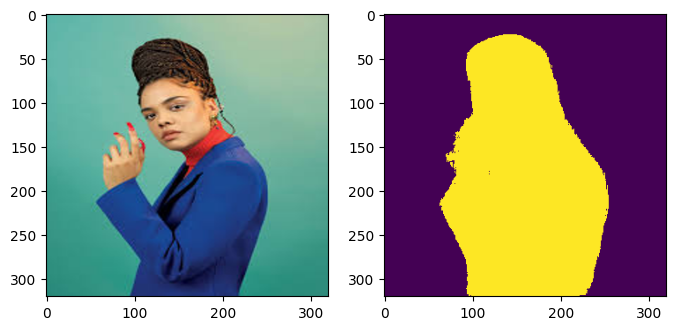

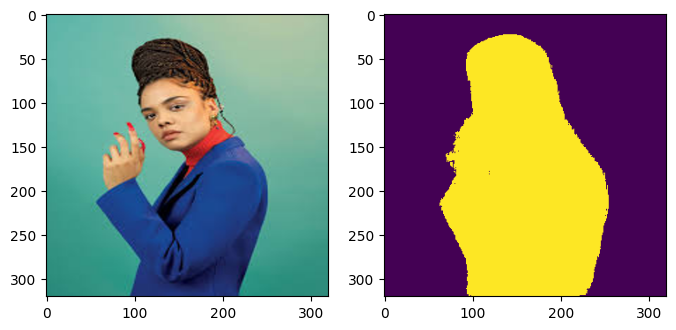

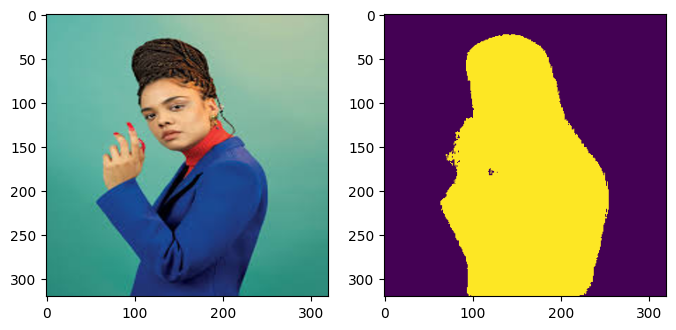

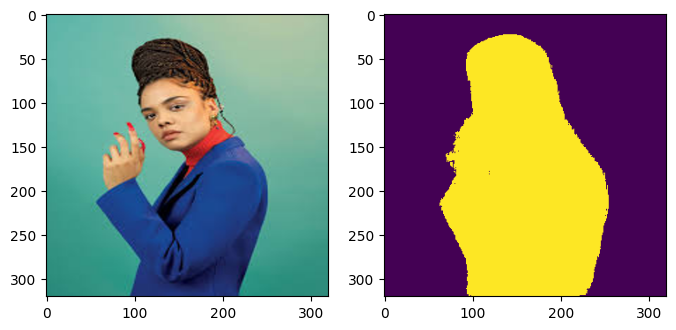

In [ ]:
##### Student code #####
def metoda_plot(model_path, ttype):
    onnx_model_path = model_path
    dtype = ttype

    ########################

    sess = ort.InferenceSession(onnx_model_path)
    input_name = sess.get_inputs()[0].name
    input_shape = sess.get_inputs()[0].shape
    input_height, input_width = input_shape[2:]

    output_name = sess.get_outputs()[0].name

    raw_img = load_image(images_path / f'9.jpg', (input_height, input_width))
    input_data = preprocess(raw_img, dtype=dtype)

    outputs = sess.run([output_name], {input_name: input_data})[0]

    predicted_mask = np.where(outputs < 0.5, 0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(raw_img)
    ax[1].imshow(predicted_mask[0][0])

model_paths = ["/content/model_fp16.onnx", "/content/model_fp32.onnx", "/content/model_uint8.onnx", "/content/preprocessed_model_fp32.onnx"]
dtypes = [np.float16, np.float32, np.float32, np.float32]

for i in range(len(model_paths)):
    metoda_plot(model_paths[i], dtypes[i])

**Zadanie 4.**</br>
Korzystając z funkcji `evaluate` porównaj wyniki skwantyzowanych modeli w formacie ONNX.


**Uwaga:** dla formatu modelu FLOAT16 dane wejściowe również muszą być w tym formacie.

In [ ]:
##### Student code #####


##### Student code #####

for i in range(len(model_paths)):
    evaluate(model_paths[i], dtypes[i])


########################
########################

Test dice score: 0.8283205036484559
Average inference time: 351.9334459655087 ms
Test dice score: 0.8282338914823318
Average inference time: 245.66762551722243 ms
Test dice score: 0.8290289168411744
Average inference time: 294.31848781034427 ms
Test dice score: 0.8282338914823318
Average inference time: 232.5867231896562 ms


---
# Materiały dodatkowe
---

- Kwantyzacja (Quantization):
  - [Practical Quantization in PyTorch](https://pytorch.org/blog/quantization-in-practice/)
  - [ONNX Quantization Overview](https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html)
- Uczenie z uwzględnieniem kwantyzacji (Quantization Aware Training):
  - [Quantization aware training TensorFlow](https://www.tensorflow.org/model_optimization/guide/quantization/training)
- Łączenie warstw (Layer Fusion):
  - [Compressing Deep Neural Networks via Layer Fusion](https://arxiv.org/pdf/2007.14917.pdf)
- Usuwaniu parametrów (Pruning):
  - [Weight pruning](https://www.tensorflow.org/model_optimization/guide/pruning)
  - biblioteka [Torch-Pruning](https://github.com/VainF/Torch-Pruning)
  - [Pruning Tutorial PyTorch](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)
  - [To prune, or not to prune: exploring the efficacy of pruning for model compression](https://arxiv.org/pdf/1710.01878.pdf)
- Klasteryzacja wag (Weight Clustering / Palettization):
  - [TensorFlow: Weight clustering](https://www.tensorflow.org/model_optimization/guide/clustering),
  - chapter 3, titled _Trained Quantization and Weight Sharing_ from [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization and Huffman Coding](https://arxiv.org/abs/1510.00149),
  - [Core ML Palettization Overview](https://apple.github.io/coremltools/docs-guides/source/post-training-palettization.html),
- Optymalizacja zbiorowa (Collaborative Optimization):
  - [Collaborative Optimization](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)
  - [Sparsity preserving clustering Keras example](https://www.tensorflow.org/model_optimization/guide/combine/sparse_clustering_example)
